# Импорт библиотек и загрузка данных

In [86]:
#
import numpy as np 
import pandas as pd 
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))


In [245]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
id_test = test['client_id']

In [153]:
# опишем несколько стандартных повторяемых функций для дальнейшей работы
#для вмзуализации данных
def hist_box(col, size = 5):
    fig, (g1, g2) = plt.subplots(1, 2, figsize = (2*size,size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    g1.hist(data[col], bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'blue') # гистограмма
    g2.boxplot(data[col], vert = False)  # выбросы
    plt.figtext(0.5, 0, col, fontsize = 16)
    plt.show
    
# Поиск выбросов
def outliers(col):
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l = perc25 - 1.5*IQR 
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(data[data[col] > r][col].count() + data[data[col] < l][col].count()))


    
#Сравнение метрик по результатам прогона модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index = metrics)
def summary_metrics(summary,col,y_valid,y_pred,y_pred_probs):
    values = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred), f1_score(y_valid,y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary

# кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

# Confusion matrix
def conf_mat(y_valid, y_pred):
    P = np.sum(y_valid==1)
    N = np.sum(y_valid==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print(tp, fp) 
    print(fn, tn)

In [154]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [155]:
#объединим тренировочный и тестовый датасеты в один для обработки признаков

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['default'] = 0 # пока заполняем нулями целевой признак в тестовом датасете

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описание признаков

* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* foreign_passport - наличие загранпаспорта
* default - флаг дефолта по кредиту

# EDA

Видим, что в основном в данных нет пропусков, кроме поля education

In [156]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [157]:
#Посмотрим, сколько долю пропусков в столбце education в массиве

print('Пропуски составляют {} % позиций'.format(data['education'].isnull().sum()/len(data.education)*100))



Пропуски составляют 0.4339615789664814 % позиций


In [158]:
# Поскольку их меньше 1%, то заменим на наиболее часто втречающееся значение
data.education = data.education.fillna(data.education.mode()[0])

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [160]:
# преобразуем дату подачи заявки в дату

from datetime import datetime
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

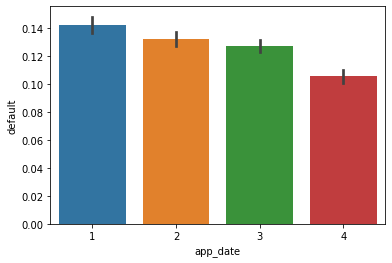

In [161]:
# посмотрим, есть ли какая-то тенденция по дефолтным клиентам в зависимости от месяца подачи заявления
sns.barplot(data=data[data['sample']==1], x=data.loc[data['sample']==1,'app_date'].dt.month, y='default')

In [162]:
#добавим новый признак app_month
data['app_month'] = data['app_date'].dt.month

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  object        
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

In [164]:
# Сам признак app_data удалим, он нам больше не понадобится:
data = data.drop('app_date', axis=1)

In [165]:
# Объединим признаки в группы: бинарные, категориальные и числовые
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_month']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income'] # client_id исключили из списка

### Обработка числовых признаков

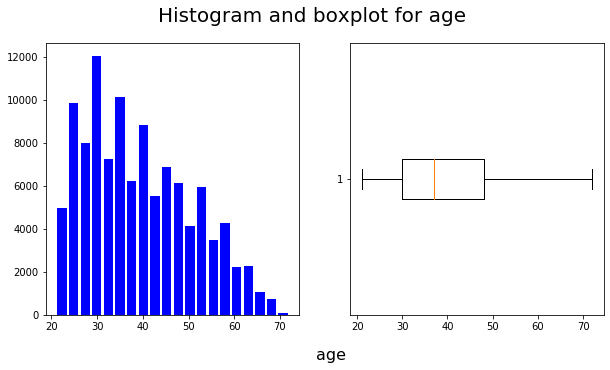

In [166]:
# столбец Age
hist_box('age')

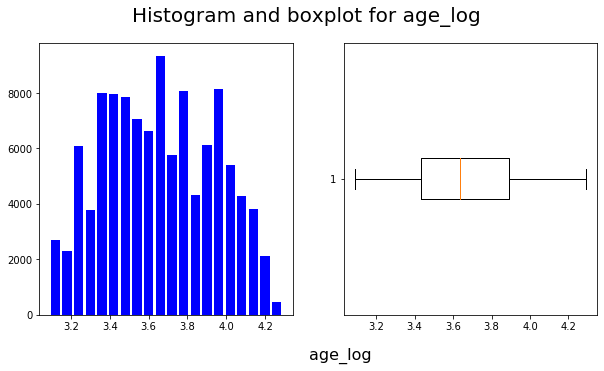

In [167]:
#Попробуем прологарифмировать:
 
data['age_log'] = np.log(data['age'] + 1)
hist_box('age_log')

In [168]:
#Распеделдение стало более нормальным

data['age'] = data['age_log']

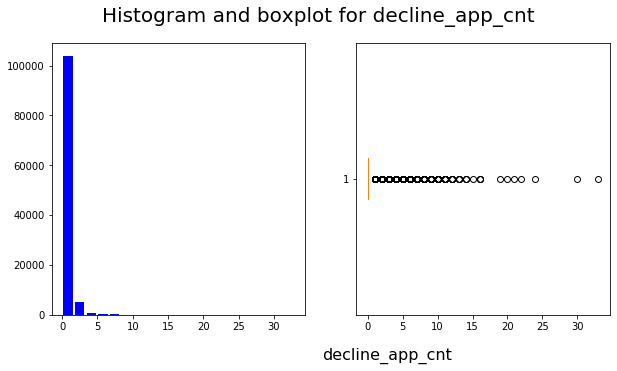

In [169]:
# посмотрим на decline_app_cnt
hist_box('decline_app_cnt')

Распределние смещенное, много выбросов. Посмотрим на значения

In [170]:
data.decline_app_cnt.value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
30    0.000009
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

In [171]:
#видим, что основная часть массива без отказов - это значение 0.  
#Можно перенести этот признак в разряд категориальных, сделав следующую категоризацию:
#0 : 0; 1-2 : 1; 3 и более : 2
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: 2 if x >=3 else (1 if x>0 else 0))

In [172]:
data.decline_app_cnt.value_counts(normalize=True)

0    0.830437
1    0.146367
2    0.023196
Name: decline_app_cnt, dtype: float64

In [173]:
cat_cols.append('decline_app_cnt')
num_cols.remove('decline_app_cnt')

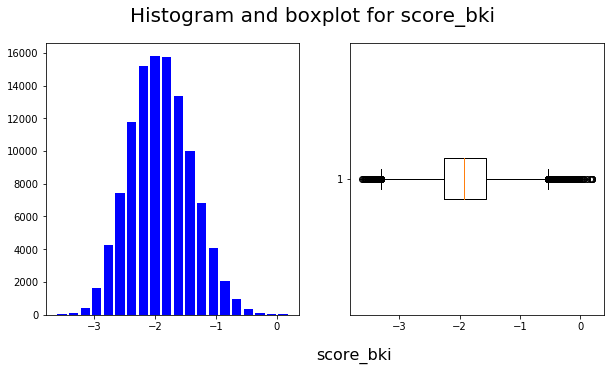

In [174]:
#смотрим следующий признак: score_bki
hist_box('score_bki')

In [175]:
#распределение нормальное, посмотрим выбросы
outliers('score_bki')

Для score_bki IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Всего 518 выбросов


В случае с признаком bki_score выбросы могут быть маркером дефлтности клиента. Оставим их

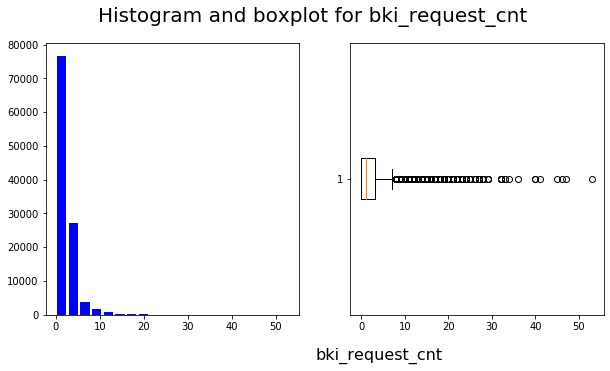

In [176]:
#У нас остались 'bki_request_cnt','income'. Смотрим на bki_request_cnt
hist_box('bki_request_cnt')

In [177]:
outliers('bki_request_cnt')

Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов


In [178]:
#выбросов уже больше, распределение ненормальное - попробуем прологарифмировать

In [179]:
data['bki_request_cnt_log'] = np.log(data['bki_request_cnt'] + 1)

In [180]:
outliers('bki_request_cnt_log')

Для bki_request_cnt_log IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Всего 15 выбросов


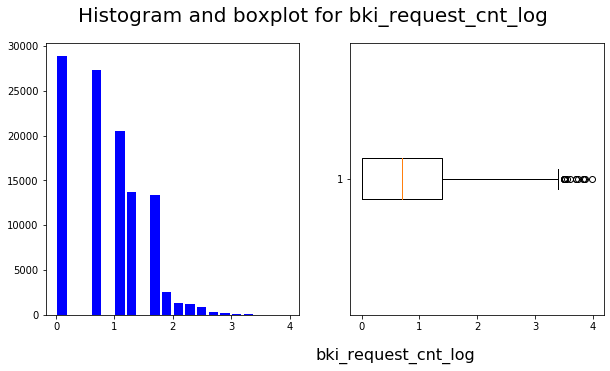

In [181]:
hist_box('bki_request_cnt_log')

Количество выбросов сильно сократилост. Оставляем логарифмированные данные


In [182]:
data['bki_request_cnt'] = data['bki_request_cnt_log']

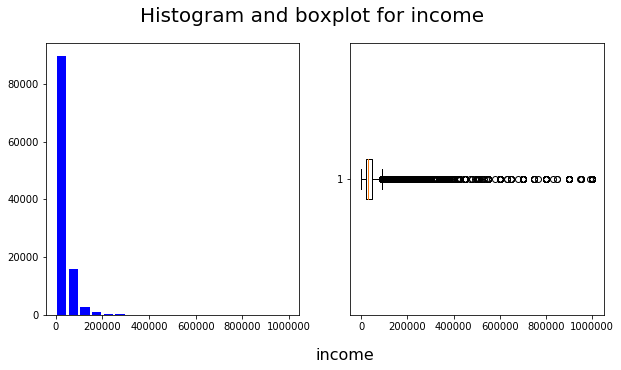

In [183]:
hist_box('income')

In [184]:
outliers('income')

Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов


In [185]:
data['income_log'] = np.log(data['income'] + 1)

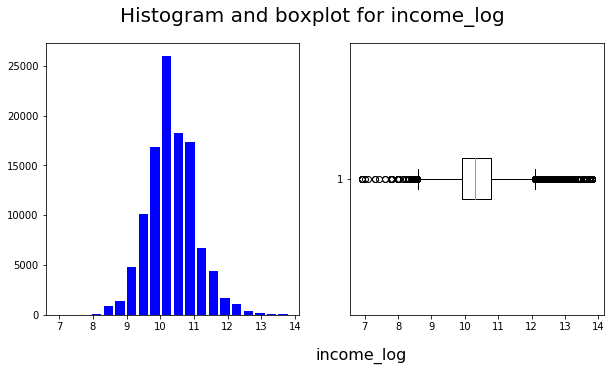

In [186]:
hist_box('income_log')

In [187]:
outliers('income_log')

Для income_log IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Всего 2609 выбросов


Логарифмированные данные выглядят лучше, оставим их

In [188]:
data['income'] = data['income_log']

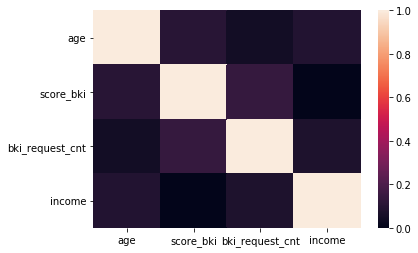

In [189]:
#теперь посмотрим на корреляцию числовых признаков
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

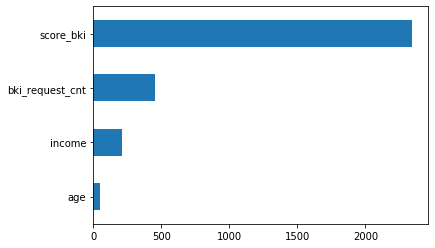

In [190]:
#Сильно выраженной корреляции между какими-либо признаками нет.
# посмотрим значимость признаков

imp_num = Series(f_classif(data[data['sample']==1][num_cols], data[data['sample']==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [191]:
# удалим не нужные стоблцы
data = data.drop(['age_log', 'bki_request_cnt_log', 'income_log'], axis = 1)

### Обработка бинарных признаков

In [192]:
# переведем бинарные признаки в числовые значения
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month
0,74835,GRD,1,3.401197,1,1,0,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0,3
1,17527,SCH,0,3.688879,0,0,2,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0,1
2,75683,UGR,1,3.931826,1,1,0,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0,3
3,26883,SCH,1,4.043051,0,0,0,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0,2
4,28862,GRD,0,3.663562,0,0,0,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,0,0,2


### Обработка категориальных признаков

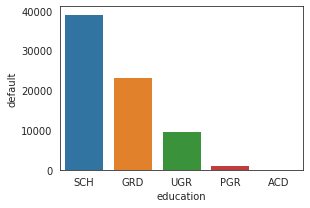

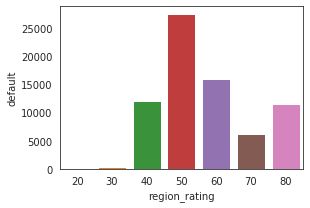

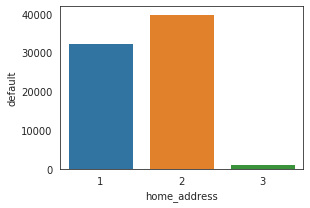

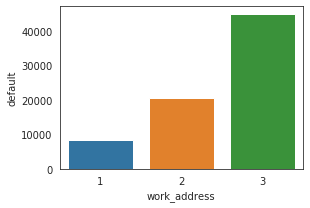

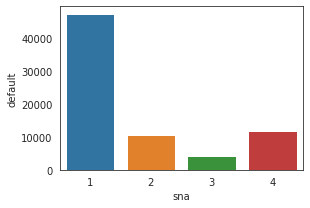

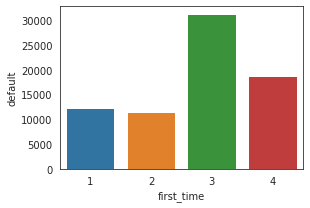

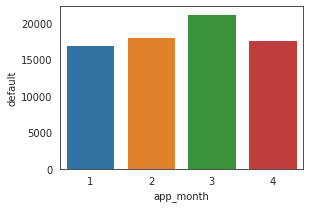

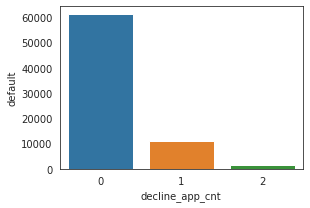

In [193]:
# посмотрим, как выглядит распределение по категориям
for i in cat_cols:
    f = plt.figure(figsize=(15, 3))
    gs = f.add_gridspec(1, 4)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.barplot(x=i, y='default', data=data[data['sample'] ==1], estimator=len)
    f.tight_layout()

In [194]:
# заменим значения в столбце education на числовые

le_edu = LabelEncoder()
le_edu.fit(data['education'])
data['education'] = le_edu.transform(data['education'])

In [195]:
#проверим
data.head(

)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month
0,74835,1,1,3.401197,1,1,0,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0,3
1,17527,3,0,3.688879,0,0,2,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0,1
2,75683,4,1,3.931826,1,1,0,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0,3
3,26883,3,1,4.043051,0,0,0,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0,2
4,28862,1,0,3.663562,0,0,0,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,0,0,2


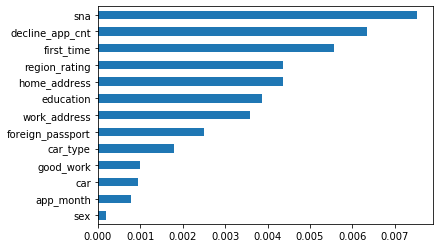

In [196]:
# посмотрим значимость бинарных и категориальных признаков
imp_cat = Series(mutual_info_classif(data[data['sample']==1][bin_cols + cat_cols], data[data['sample']==1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [197]:
# заменим все категориальные признаки на dummi переменные

data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          110148 non-null  int64  
 1   sex                110148 non-null  int32  
 2   age                110148 non-null  float64
 3   car                110148 non-null  int32  
 4   car_type           110148 non-null  int32  
 5   good_work          110148 non-null  int64  
 6   score_bki          110148 non-null  float64
 7   bki_request_cnt    110148 non-null  float64
 8   income             110148 non-null  float64
 9   foreign_passport   110148 non-null  int32  
 10  sample             110148 non-null  int64  
 11  default            110148 non-null  int64  
 12  education_0        110148 non-null  uint8  
 13  education_1        110148 non-null  uint8  
 14  education_2        110148 non-null  uint8  
 15  education_3        110148 non-null  uint8  
 16  ed

In [199]:
# удалим столбец client_id, он нам не нужен для построения можеди
data = data.drop('client_id', axis=1)


# Построение и обучение модели


In [200]:
# разделим выборку обратно на train и test
train = data[data['sample']== 1].drop(['sample'], axis=1)
test = data[data['sample']== 0].drop(['sample'], axis=1)

In [201]:
X = train.drop(['default'], axis=1).values
y = train['default'].values

In [202]:
# разделим теперь train на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [203]:
lr = LogisticRegression(random_state=RANDOM_SEED,max_iter=10000)

In [204]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [205]:
valid = lr.predict_proba(X_valid)
y_pred_valid = valid[:,1]

y_pred = lr.predict(X_valid)

In [206]:
# посмотрим метрики
summary_metrics(summary,'model_1',y_valid,y_pred,y_pred_valid)

,model_1
accuracy,0.874864
precision,0.403846
recall,0.022989
f1_score,0.043501
ROC_AUC,0.744557


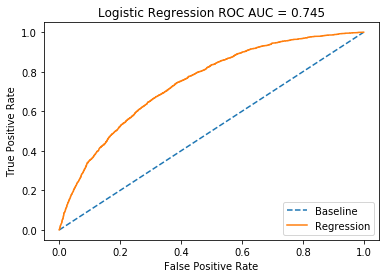

In [207]:
# построим кривую roc
roc_auc_curve(y_valid, y_pred_valid)

In [208]:
# и выведем confusion matrix
conf_mat(y_valid, y_pred)

Positive: 1827, Negative: 12933
42 62
1785 12871


из 1827 дефолтов мы предсказали только 42, метрика recall & f1-score очень низкие

Попробуем улучшить модель, подобрав оптимальные параметры 

In [209]:
# попробуем подобрать параметры

C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)



In [ ]:
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

In [211]:
# обучаем модель с подобранными параметрами
model_best_params = LogisticRegression(C = 0.1,
                                      class_weight = 'balanced',
                                      dual = False,
                                      fit_intercept = True,
                                      intercept_scaling = 1,
                                      l1_ratio = None,
                                      max_iter = 1000,
                                      multi_class = 'auto',
                                      n_jobs = None,
                                      penalty = 'l1',
                                      random_state = 42,
                                      solver = 'liblinear',
                                      tol = 0.001,
                                      verbose = 0,
                                      warm_start = False)

In [212]:
model_best_params.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.001)

In [213]:
valid = model_best_params.predict_proba(X_valid)
y_pred_valid = valid[:,1]

y_pred = model_best_params.predict(X_valid)

In [214]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_2',y_valid,y_pred,y_pred_valid)

,model_1,model_2
accuracy,0.874864,0.670596
precision,0.403846,0.225439
recall,0.022989,0.681992
f1_score,0.043501,0.338863
ROC_AUC,0.744557,0.744296


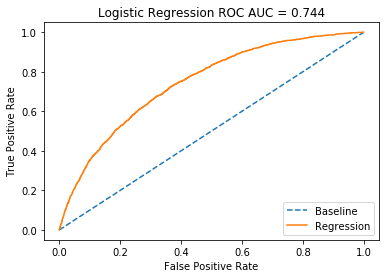

In [215]:
roc_auc_curve(y_valid, y_pred_valid)

In [216]:
conf_mat(y_valid, y_pred)

Positive: 1827, Negative: 12933
1246 4281
581 8652


Метрики accuracy и precision ухудшились, зато сильно улучшилась метрика recall и f1. 
Попробуем применить Undersampling, чтобы сделать нашу выборку сбалансированной

In [217]:
from imblearn.under_sampling import RandomUnderSampler

In [218]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

In [219]:
(X_us.shape, y_us.shape)

((18744, 42), (18744,))

In [220]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=RANDOM_SEED)

In [221]:
model_us = LogisticRegression(C = 0.1,
                                      dual = False,
                                      fit_intercept = True,
                                      intercept_scaling = 1,
                                      l1_ratio = None,
                                      max_iter = 1000,
                                      multi_class = 'auto',
                                      n_jobs = None,
                                      penalty = 'l1',
                                      random_state = 42,
                                      solver = 'liblinear',
                                      tol = 0.001,
                                      verbose = 0,
                                      warm_start = False)

In [222]:
model_us.fit(X_train_us, y_train_us)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear', tol=0.001)

In [223]:
valid = model_us.predict_proba(X_test_us)
y_pred_valid = valid[:,1]

y_pred = model_us.predict(X_test_us)

In [224]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_us',y_test_us,y_pred,y_pred_probs)

,model_1,model_2,model_us
accuracy,0.874864,0.670596,0.679467
precision,0.403846,0.225439,0.686108
recall,0.022989,0.681992,0.679622
f1_score,0.043501,0.338863,0.682850
ROC_AUC,0.744557,0.744296,0.750356


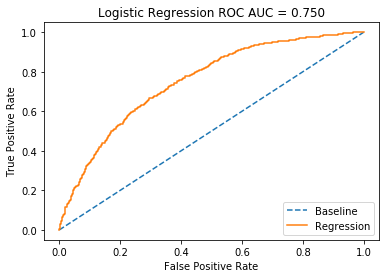

In [225]:
roc_auc_curve(y_test_us, y_pred_probs)

In [226]:
conf_mat(y_test_us, y_pred)

Positive: 952, Negative: 923
647 296
305 627


Видим, что у модели все метрики стали намного лучше. ЕЕ и отпрааляем на submission

# Submission

In [227]:
X_test = test.drop(['default'], axis=1)

In [228]:
y_pred_prob = model_us.predict_proba(X_test)[:,1]

In [229]:
test

,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,...,first_time_2,first_time_3,first_time_4,app_month_1,app_month_2,app_month_3,app_month_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2
0,1,3.401197,1,1,0,-2.271884,1.386294,10.819798,0,0,...,0,0,1,0,0,1,0,1,0,0
1,0,3.688879,0,0,0,-1.504999,1.098612,8.517393,0,0,...,0,1,0,1,0,0,0,0,0,1
2,1,3.931826,1,1,0,-1.691339,0.693147,10.308986,1,0,...,0,1,0,0,0,1,0,1,0,0
3,1,4.043051,0,0,0,-2.374182,0.693147,9.741027,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0,3.663562,0,0,0,-2.487502,0.000000,11.695255,0,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,0,3.637586,0,0,0,-1.744976,1.386294,9.615872,0,0,...,0,0,0,0,0,1,0,0,1,0
36345,0,4.174387,1,1,0,-2.293781,1.386294,12.206078,0,0,...,0,0,1,0,0,0,1,1,0,0
36346,1,3.465736,0,0,0,-0.940752,0.693147,11.002117,0,0,...,1,0,0,0,0,1,0,0,1,0
36347,0,3.332205,0,0,0,-1.242392,1.098612,10.308986,0,0,...,0,0,0,1,0,0,0,0,1,0


In [248]:
submit = pd.DataFrame({'client_id': id_test,
                           'default': y_pred_prob})

In [249]:
submit.head()

,client_id,default
0,74835,0.212290
1,17527,0.713686
2,75683,0.310287
3,26883,0.389543
4,28862,0.155143


In [250]:
submit.to_csv('submission_us.csv', index=False)

In [251]:
submit

,client_id,default
0,74835,0.212290
1,17527,0.713686
2,75683,0.310287
3,26883,0.389543
4,28862,0.155143
...,...,...
36344,83775,0.786760
36345,106254,0.146112
36346,81852,0.766684
36347,1971,0.575273
